In [ ]:
#Import PyCBC
import sys
!{sys.executable} -m pip install pycbc ligo-common --no-cache-dir

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 319.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 367.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 303.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.1/203.1 kB 415.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 229.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 285.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.7/168.7 kB 429.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.0/115.0 kB 394.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.1/48.1 MB 347.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 397.0 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
ERROR: pip's dependenc

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import sys
from scipy.interpolate import Akima1DInterpolator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from pycbc.waveform import get_td_waveform
from pycbc.detector import Detector

#Initial Conditions
num_samples = 1000
num_points = 3000
noise_level = 0.3   #30% noise relative to signal peak


#Generating Clean Waveforms
def make_waveform(total_mass, effective_distance=100, num_points=3000):
    mass1 = total_mass / 2
    mass2 = total_mass / 2
    apx = "IMRPhenomD"

    #Generate the waveform
    hp, hc = get_td_waveform(approximant=apx,
                            mass1=mass1, mass2=mass2,
                            spin1z=0.9, spin2z=0.9,
                            distance=effective_distance,
                            inclination=0, coa_phase=2.45,
                            delta_t=1.0/4096, f_lower=40)

    #Detector Projections (H1)
    det_h1 = Detector('H1')
    end_time, dec, ra, pol = 1292529720, 0.65, 4.67, 2.34
    hp.start_time += end_time
    hc.start_time += end_time

    signal_h1 = det_h1.project_wave(hp, hc, ra, dec, pol)

    time = signal_h1.sample_times.numpy()
    signal = signal_h1.numpy()

    #Masking near-zero points to focus on the "Chirp"
    mask = np.abs(np.diff(signal, prepend=0)) > (0.0001 * np.max(np.abs(signal)))
    time, signal = time[mask], signal[mask]

    if len(time) < 10: # Safety check
        return None, None

    #Normalizing Time to [0, 1]
    time = (time - time[0]) / (time[-1] - time[0])

    #Interpolation to fixed length
    interpolator = Akima1DInterpolator(time, signal)
    sample_points = np.linspace(0, 1, num_points)
    interpolated_signal = interpolator(sample_points)

    #Final cleanup: Ensure no NaNs from interpolation
    interpolated_signal = np.nan_to_num(interpolated_signal)

    return sample_points, interpolated_signal

#Generating Data
print(f"Generating {num_samples} noisy waveforms...")
masses = np.linspace(50, 600, num_samples)
X_data = []
y_data = []
signals = []
valid_masses = []

for m in masses:
    t, s = make_waveform(m, num_points=num_points)
    if s is not None:
        signals.append(s)
        valid_masses.append(m)

X = np.array(signals)
y = np.array(valid_masses)

#Expanding dims for CNN: (Samples, Time, Channels)
X = X[..., np.newaxis]

#Normalize X (Strain) to [-1, 1]
X = X / np.max(np.abs(X), axis=1, keepdims=True)

#Normalize y (Masses) to [0, 1] for better convergence
y_min, y_max = y.min(), y.max()
y_scaled = (y - y_min) / (y_max - y_min)

#Generating Waveforms with Gaussian Noise
def make_noisy_waveform(total_mass, noise_scale=0.2, num_points=3000):
    t, clean_signal = make_waveform(total_mass, num_points=num_points)

    if clean_signal is None:
        return None, None

    #Normalizing clean signal
    max_amp = np.max(np.abs(clean_signal))
    if max_amp == 0: return None, None
    clean_signal = clean_signal / max_amp

    #Generating Gaussian Noise
    noise = np.random.normal(0, noise_scale, num_points)

    #Combining Gaussian Noise and Normalized Noise
    noisy_signal = clean_signal + noise

    return t, noisy_signal

for m in masses:
    _, s = make_noisy_waveform(m, noise_scale=noise_level, num_points=num_points)
    if s is not None:
        X_data.append(s)
        y_data.append(m)

X = np.array(X_data)[..., np.newaxis] # Shape: (Samples, 3000, 1)

#Log-transforming the target (Total Mass)
y_log = np.log10(y_data)

#Splitting 15% of Training Data for Test Data
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y_log, test_size=0.15, random_state=42, shuffle=True
)

#Model
model = Sequential([
    Input(shape=(num_points, 1)),
    Conv1D(32, 16, activation="relu"),
    MaxPooling1D(4),
    Conv1D(64, 8, activation="relu"),
    MaxPooling1D(4),
    Conv1D(128, 4, activation="relu"),
    MaxPooling1D(4),
    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.2), # Prevents overfitting on noise patterns
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary();

#Training
#EarlyStopping monitors the 'val_loss' to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    X_train_val, y_train_val,
    epochs=100,
    batch_size=32,
    validation_split=0.2, # Takes 20% of X_train_val for experimentation
    callbacks=[early_stop],
    verbose=1
)

#Visuals

#Converting predictions back from Log10 to Solar Masses
preds_log = model.predict(X).flatten()
preds_mass = 10**preds_log
true_mass = 10**y_log

plt.figure(figsize=(10, 5))
plt.scatter(true_mass, preds_mass, alpha=0.3, s=10, label="Predictions")
plt.plot([50, 600], [50, 600], color='red', linestyle='--', label="Ideal")
plt.title(f"Mass Estimation with Noise Level: {noise_level}")
plt.xlabel("True Mass ($M_{\odot}$)")
plt.ylabel("Predicted Mass ($M_{\odot}$)")
plt.legend()
plt.show()

#Test Data Trial
print("\n--- FINAL TEST SET RESULTS ---")
test_mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Mean Squared Error: {test_mse:.5f}")

#Converting back to Solar Masses for interpretation
preds_test_log = model.predict(X_test).flatten()
preds_mass2 = 10**preds_test_log
true_mass2 = 10**y_test

#Visualizing Results
plt.figure(figsize=(12, 5))

#Training Data Vs. Validation Data
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss (Experimentation)')
plt.title('Learning Curves')
plt.xlabel('Epoch')
plt.ylabel('MSE (Log Scale)')
plt.legend()

# Test Data Performance
plt.subplot(1, 2, 2)
plt.scatter(true_mass2, preds_mass2, alpha=0.5, color='green')
plt.plot([50, 600], [50, 600], 'r--', label='Perfect Prediction')
plt.title('Accuracy on Final Test Set')
plt.xlabel('Actual Mass ($M_{\odot}$)')
plt.ylabel('Predicted Mass ($M_{\odot}$)')
plt.legend()

plt.tight_layout()
plt.show()

<>:170: SyntaxWarning: invalid escape sequence '\o'
<>:171: SyntaxWarning: invalid escape sequence '\o'
<>:202: SyntaxWarning: invalid escape sequence '\o'
<>:203: SyntaxWarning: invalid escape sequence '\o'
<>:170: SyntaxWarning: invalid escape sequence '\o'
<>:171: SyntaxWarning: invalid escape sequence '\o'
<>:202: SyntaxWarning: invalid escape sequence '\o'
<>:203: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-1046814036.py:170: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel("True Mass ($M_{\odot}$)")
/tmp/ipython-input-1046814036.py:171: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel("Predicted Mass ($M_{\odot}$)")
/tmp/ipython-input-1046814036.py:202: SyntaxWarning: invalid escape sequence '\o'
  plt.xlabel('Actual Mass ($M_{\odot}$)')
/tmp/ipython-input-1046814036.py:203: SyntaxWarning: invalid escape sequence '\o'
  plt.ylabel('Predicted Mass ($M_{\odot}$)')


Generating 1000 noisy waveforms...


KeyboardInterrupt: 

<>:18: SyntaxWarning: invalid escape sequence '\o'
<>:18: SyntaxWarning: invalid escape sequence '\o'
/tmp/ipython-input-1645235.py:18: SyntaxWarning: invalid escape sequence '\o'
  plt.plot(t, s_noisy, label=f'Mass: {m}$M_\odot$', color=colors[i], alpha=0.8)


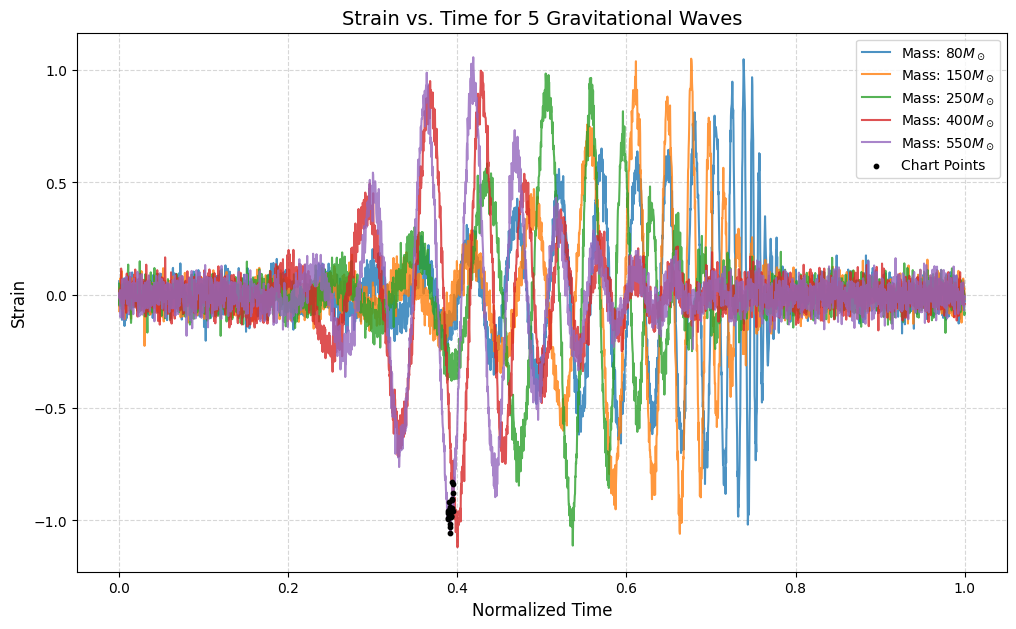


--- Data Points Chart (for 550 Solar Mass Wave) ---
   Time    Strain      Type
0.38846 -0.993454    Before
0.38880 -0.957458    Before
0.38913 -0.968035    Before
0.38946 -0.986708    Before
0.38980 -0.952552    Before
0.39013 -0.918079    Before
0.39046 -0.965973    Before
0.39080 -1.014752    Before
0.39113 -1.029930    Before
0.39146 -0.942033    Before
0.39180 -1.057210 PEAK/PRED
0.39213 -0.981595     After
0.39246 -0.978112     After
0.39280 -0.984495     After
0.39313 -0.905152     After
0.39346 -0.944846     After
0.39380 -0.827956     After
0.39413 -0.907327     After
0.39446 -0.877774     After
0.39480 -0.840172     After
0.39513 -0.958331     After


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 1. Define 5 different masses to showcase variety (similar to your image)
sample_masses = [80, 150, 250, 400, 550]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'] # Standard palette
plt.figure(figsize=(12, 7))

# Store data for the chart (using the last mass in the loop)
final_chart_df = None

for i, m in enumerate(sample_masses):
    # Use your existing make_noisy_waveform function
    t, s_noisy = make_noisy_waveform(m, noise_scale=0.05, num_points=num_points)

    # Plotting the line
    plt.plot(t, s_noisy, label=f'Mass: {m}$M_\odot$', color=colors[i], alpha=0.8)

    # For the last wave, let's prepare the 10-point data chart
    if i == len(sample_masses) - 1:
        peak_idx = np.argmax(np.abs(s_noisy))
        indices = np.arange(peak_idx - 10, peak_idx + 11)

        # Highlight these points on the graph
        plt.scatter(t[indices], s_noisy[indices], color='black', s=10, zorder=5, label='Chart Points')

        final_chart_df = pd.DataFrame({
            "Time": np.round(t[indices], 5),
            "Strain": s_noisy[indices],
            "Type": ["Before"]*10 + ["PEAK/PRED"] + ["After"]*10
        })

# Formatting the plot to match your reference
plt.title("Strain vs. Time for 5 Gravitational Waves", fontsize=14)
plt.xlabel("Normalized Time", fontsize=12)
plt.ylabel("Strain", fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# Display the requested data chart
print(f"\n--- Data Points Chart (for {sample_masses[-1]} Solar Mass Wave) ---")
print(final_chart_df.to_string(index=False))

In [ ]:
# 1. Convert log-scale predictions and true values back to Solar Masses
# Ensure we are using the test set (unseen data)
preds_test_log = model.predict(X_test).flatten()
true_masses = 10**y_test
predicted_masses = 10**preds_test_log

# 2. Create the Comparison DataFrame
comparison_df = pd.DataFrame({
    'True Mass (M☉)': true_masses,
    'Predicted Mass (M☉)': predicted_masses,
    'Absolute Error (M☉)': np.abs(true_masses - predicted_masses),
    'Percent Error (%)': np.abs((true_masses - predicted_masses) / true_masses) * 100
})

# 3. Sort by True Mass to see performance across the mass range
comparison_df = comparison_df.sort_values(by='True Mass (M☉)')

# 4. Display the first 20 results
print("\nTEST SET MASS COMPARISON TABLE")
print(comparison_df.head(20).to_string(index=False))

# Optional: Save to CSV for external analysis
# comparison_df.to_csv("mass_predictions.csv", index=False)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 

--- TEST SET MASS COMPARISON TABLE ---
 True Mass (M☉)  Predicted Mass (M☉)  Absolute Error (M☉)  Percent Error (%)
      55.505506            68.813408            13.307902          23.975824
      62.662663            57.026138             5.636524           8.995028
      63.763764            71.043251             7.279487          11.416339
      66.516517            79.820641            13.304124          20.001234
      71.471471            77.728394             6.256922           8.754433
      74.224224            66.739861             7.484364          10.083452
      79.729730            88.270859             8.541129          10.712603
      80.280280           109.672256            29.391976          36.611701
      82.482482           104.107559            21.625077          26.217781
      84.684685           109.090630            24.405945          28.819786
      86.336336           127.569191            41.232855          47.75840